In [134]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Add, Subtract, Concatenate
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from scipy.special import expit as sigmoid

# Build and compile a basic model

In [2]:
input_tensor = Input(shape=(1,))
output_layer = Dense(1, name='predicted_score_diff')

In [3]:
output_tensor = output_layer(input_tensor)
model = Model(input_tensor, output_tensor)

In [4]:
model.compile(optimizer='adam', loss='mae')

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
predicted_score_diff (Dense) (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


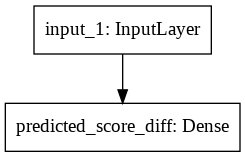

In [6]:
plot_model(model)

### Load data, split between training and testing

In [7]:
games = pd.read_excel('basketball_data.xlsx')

In [8]:
predictors = games[['seed_diff']]

In [9]:
train_X, test_X, train_Y, test_Y = np.array(train_test_split(predictors, games['score_diff'], test_size=0.20))

### Fit the model

In [10]:
model.fit(np.array(train_X), # input
         np.array(train_Y), # output
         epochs=1, 
         batch_size=128, # how many rows are used for each step of stochastic gradient descent
         validation_split=0.10,
         verbose=True)

Train on 3048 samples, validate on 339 samples
3048/3048 [==============================] - 1s 170us/sample - loss: 9.1389 - val_loss: 9.4637


### Evaluate model

In [11]:
print(model.evaluate(np.array(test_X), np.array(test_Y), verbose=False))

9.196651266203862


# Category embeddings
Advanced type layer only available in deep learning libraries. Useful for dealing with high cardinality categorical data (here team id var). Also useful for text data like word-to vec-models. Thus, I flatten the embeddings from 3d to 2d. 

In [12]:
input_tensor = Input(shape=(1,))
n_teams = 10887
embed_layer = Embedding(input_dim=n_teams,
                       input_length=1,
                       output_dim=1,
                       name='Team_strength_lookup')
embed_tensor = embed_layer(input_tensor)

Flatten the data. Third dimension can be useful when dealing with text or images, but not so much here. 

In [13]:
flatten_tensor = Flatten()(embed_tensor)

In [14]:
model = Model(input_tensor, flatten_tensor)

### Read in a larger dataset directly from github

In [15]:
url = 'https://raw.githubusercontent.com/corybaird/Keras_Basics_Python/master/basketball_data/games_season.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [16]:
df.shape

(312178, 7)

In [17]:
n_teams = df['team_1'].nunique()

In [18]:
team_lookup = Embedding(input_dim=n_teams, #  embedding layer that maps each team ID to a single number representing that team's strengt
                       output_dim=1, # as we want to represent the teams by a single number
                       input_length=1, # as each team is represented by exactly one id
                       name='Team-strength')

### Define the model for larger data with embedding

In [19]:
teamid_in = Input(shape=(1,)) # Create an input layer for the team ID

In [20]:
strength_lookup = team_lookup(teamid_in) # Lookup the input in the team strength embedding layer
strength_lookup_flat = Flatten()(strength_lookup) # flatten

In [21]:
#Create a model that uses the 1D input as input and flattened team strength as output
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

In [22]:
# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

Lookup the team inputs in the shared team strength model. The two inputs will share the same weights.

We want to learn a strength rating for each team, such that if any pair of teams plays each other, we can predict the score, even if those two teams have never played before. Furthermore, we want the strength rating to be the same, regardless of whether the team is the home team or the away team.

In [23]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

### Merging layers
Many options (add, substract, multiply, concatenate)

In [24]:
in_tensor_1 = Input((1,))
in_tensor_2 = Input((1,))
out_tensor = Add()([in_tensor_1, in_tensor_2])

In [25]:
in_tensor_3 = Input((1,))
out_tensor = Add()([in_tensor_1, in_tensor_2, in_tensor_1])

In [26]:
model = Model([in_tensor_1, in_tensor_2], out_tensor)

In [27]:
model.compile(optimizer='adam', loss='mean_absolute_error')

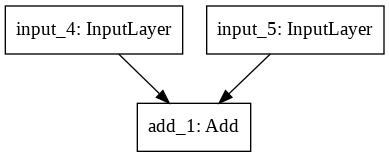

In [28]:
plot_model(model)

### Create model from previous data

In [29]:
# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

In [30]:
# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

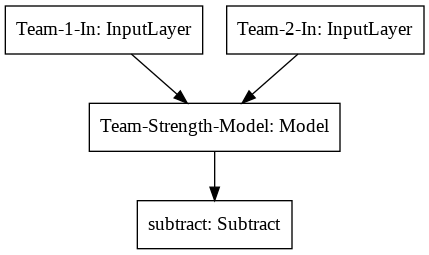

In [31]:
plot_model(model)

### Teach the model new strenght rating for each team

In [32]:
# Get the team_1 column from the regular season data
input_1 = np.array(df['team_1'])

# Get the team_2 column from the regular season data
input_2 = np.array(df['team_2'])

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          np.array(df['score_diff']),
          epochs=1,
          batch_size=2048,
          validation_split=0.10,
          verbose=True)

Train on 280960 samples, validate on 31218 samples
280960/280960 [==============================] - 1s 3us/sample - loss: 12.1198 - val_loss: 11.8377


### Evaluate the model

In [33]:
print(model.evaluate([input_1, input_2], np.array(df['score_diff']), verbose=False))

12.079559300767281


## 3-input models
Works almost exactly like previous models

In [67]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [68]:
# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Split data for testing and training

In [69]:
predictors = df.drop('score_diff', axis=1)
train_X, test_X, train_Y, test_Y = np.array(train_test_split(predictors, df['score_diff'], test_size=0.20))

In [70]:
# Get the team_1 column from the regular season data
input_1 = np.array(train_X['team_1'])

# Get the team_2 column from the regular season data
input_2 = np.array(train_X['team_2'])

# Get the home column from the regular season data
home_input = np.array(train_X['home'])

# Fit the model to the games_season dataset
model.fit([input_1, input_2, home_input],
          np.array(train_Y),
          epochs=1,
          verbose=False,
          validation_split=0.10,
          batch_size=2048)

In [71]:
model.evaluate([np.array(test_X['team_1']), np.array(test_X['team_2']), np.array(test_X['home'])], 
                         np.array(test_Y), verbose=False)

12.050425793544328

## Summarising and plotting models

In [72]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
Home-In (InputLayer)            [(None, 1)]          0                                      

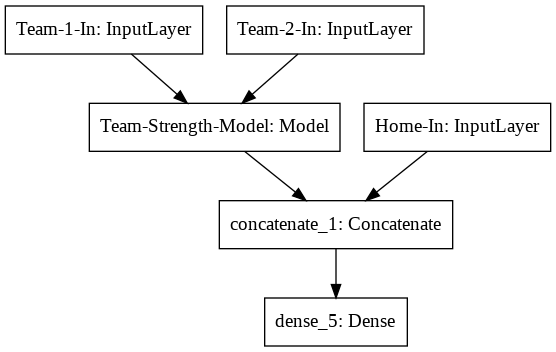

In [73]:
plot_model(model)

## Stacking models

Below I am changing data type to float64 since I was getting error with int64 ("TypeError: Tensors in list passed to 'values' of 'Concat' Op have types [float64, float32] that don't all match")

In [74]:
inp1 = np.array(games['team_1'].astype('float64'))
inp2 = np.array(games['team_2'].astype('float64'))
inp3 = np.array(games['home'].astype('float64'))

In [75]:
games['preds'] = model.predict([inp1, inp2, inp3])

In [76]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

split the test and training data again since we have added a new preds col to the df

In [77]:
predictors = games.drop('score_diff', axis=1)
train_X, test_X, train_Y, test_Y = train_test_split(predictors, games['score_diff'], test_size=0.25)

train_X = np.array(train_X[['home', 'seed_diff', 'preds']])
test_X = np.array(test_X[['home', 'seed_diff', 'preds']])
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

In [78]:
# Fit the model
model.fit(train_X,
          train_Y,
          epochs=1,
          verbose=True)

Train on 3175 samples
3175/3175 [==============================] - 0s 116us/sample - loss: 10.2260


In [79]:
# Evaluate the model on the games_tourney_test dataset
print(model.evaluate(test_X, test_Y, verbose=False))

10.115318585612844


# Models with two outputs

In [80]:
input_tensor = Input(shape=(1,))
output_tensor = Dense(2)(input_tensor)

In [81]:
model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [82]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


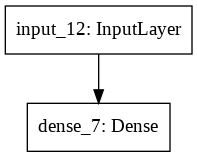

In [83]:
plot_model(model)

In [84]:
predictors = games.drop(['score_1', 'score_2'], axis=1)
train_X, test_X, train_Y, test_Y = train_test_split(predictors, games[['score_1', 'score_2']], test_size=0.25)

train_X = np.array(train_X[['seed_diff']])
test_X = np.array(test_X[['seed_diff']])
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

In [85]:
model.fit(train_X, train_Y, epochs=500, verbose=False)

In [86]:
model.get_weights()

[array([[ 0.31479964, -0.86270446]], dtype=float32),
 array([49.929375, 49.931324], dtype=float32)]

In [119]:
model.evaluate(test_X, test_Y, verbose=False)

60.295760628562306

### Model with two inputs and two outputs

In [108]:
# Define the input
input_tensor = Input(shape=(2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [109]:
predictors = games.drop(['score_1', 'score_2'], axis=1)
train_X, test_X, train_Y, test_Y = train_test_split(predictors, games[['score_1', 'score_2']], test_size=0.15)

train_X = np.array(train_X[['seed_diff', 'preds']])
test_X = np.array(test_X[['seed_diff', 'preds']])
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)

print(train_X.shape)
print(test_X.shape)

(3598, 2)
(636, 2)


In [116]:
# Fit the model
model.fit(train_X,
          train_Y,
          verbose=False,
          epochs=1000,
          batch_size=700)

In [117]:
# Print the model's weights
print(model.get_weights())

# Print the column means of the training data
print(games.mean())

[array([[ 0.9144271,  0.486746 ],
       [11.696901 , 10.36145  ]], dtype=float32), array([10.500613, 10.500613], dtype=float32)]
season        2001.193198
team_1        5589.146906
team_2        5589.146906
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.131318
score_2         71.131318
won              0.500000
preds            0.045736
dtype: float64


In [118]:
# Evaluate the model on the tournament test data
print(model.evaluate(test_X, test_Y, verbose=False))

60.295760628562306


## Simple model for both classification and regression

In [121]:
input_tensor = Input(shape=(1,))
output_tensor_reg = Dense(1)(input_tensor)
output_tensor_class = Dense(1, activation='sigmoid')(output_tensor_reg)

In [122]:
model = Model(input_tensor, [output_tensor_reg, output_tensor_class])
model.compile(optimizer='adam', loss=['mean_absolute_error', 'binary_crossentropy'])

In [123]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


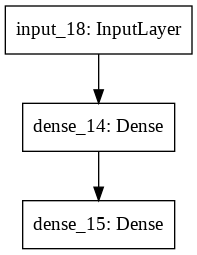

In [124]:
plot_model(model)

In [125]:
predictors = games.drop(['score_diff', 'won'], axis=1)
train_X, test_X, train_Y, test_Y = train_test_split(predictors, games[['score_diff', 'won']], test_size=0.15)

train_X = np.array(train_X[['seed_diff']])
test_X = np.array(test_X[['seed_diff']])

train_Y_reg = np.array(train_Y[['score_diff']])
test_Y_reg = np.array(test_Y[['score_diff']])

train_Y_class = np.array(train_Y[['won']])
test_Y_class = np.array(test_Y[['won']])

print(train_X.shape)
print(test_X.shape)

(3598, 1)
(636, 1)


In [127]:
model.fit(train_X, [train_Y_reg, train_Y_class], epochs=100, verbose=False)

In [128]:
model.get_weights()

[array([[1.1509178]], dtype=float32),
 array([0.05734654], dtype=float32),
 array([[0.14079416]], dtype=float32),
 array([0.01159938], dtype=float32)]

In [130]:
print(sigmoid(1 * 0.14079416 + 0.01159938))

0.5380248234221523


In [132]:
model.evaluate(test_X, [test_Y_reg, test_Y_class], verbose=False)

[10.190401431149656, 9.642225, 0.55515534]

### Creating a second model here

Predict the score difference, instead of both team's scores and then I will predict the probability that team 1 won the game.

In [137]:
# Create an input layer with 2 columns
input_tensor = Input(shape=(2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

In [138]:
predictors = games.drop(['score_diff', 'won'], axis=1)
train_X, test_X, train_Y, test_Y = train_test_split(predictors, games[['score_diff', 'won']], test_size=0.15)

train_X = np.array(train_X[['seed_diff', 'preds']])
test_X = np.array(test_X[['seed_diff', 'preds']])

train_Y_reg = np.array(train_Y[['score_diff']])
test_Y_reg = np.array(test_Y[['score_diff']])

train_Y_class = np.array(train_Y[['won']])
test_Y_class = np.array(test_Y[['won']])

print(train_X.shape)
print(test_X.shape)

(3598, 2)
(636, 2)


In [140]:
# Import the Adam optimizer

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(train_X,
          [train_Y_reg, train_Y_class],
          epochs=100,
          verbose=False,
          batch_size=1000)

In [141]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games.mean())

[array([[1.1621205],
       [1.8157172]], dtype=float32), array([[0.14369091]], dtype=float32)]
season        2001.193198
team_1        5589.146906
team_2        5589.146906
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.131318
score_2         71.131318
won              0.500000
preds            0.045736
dtype: float64


Last weight of the model converts the predicted score difference to a predicted win probability. 
    
If we multiply the predicted score difference by the last weight of the model and then apply the sigmoid function, we get the win probability of the game.

In [142]:
weight = 0.14369091

# Print the approximate win probability of a predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability of a predicted blowout game
print(sigmoid(10 * weight))

0.535861046571388
0.8079755514751746


In [143]:
# Evaluate the model on new data
print(model.evaluate(test_X,
               [test_Y_reg, test_Y_class], verbose=False))

[9.811801136664624, 9.267303, 0.53903955]
